### Graham Kerr
#### graham.s.kerr@NASA.gov; kerrg@cua.edu

<H1 font size="+3" style="color:red">
SPICE (HSR)<br>
-- SPICE L2 data and Python
</H1>

<b>This notebook will run through examples of</b> <br>
- Reading L2 SPICE data into python, via sunraster
- Manipulating and plotting the sunraster object
- Selecting wavelength pixels given physical values (these need to be in pixel space not wavelength)
- Integrate over wavelength (using both sunraster's rebin routine and also using the trapezoidal rule)

Most of these actions use some ancillary codes that I have collected in SPICE_anal.py

In [1]:
##
## Import some modules
##


## The first path points to the location of utils.py... you don't need this for the 
## notebook to run, just comment out if you don't have a copy.
## The second path points to the location of SPICE_anal.py
import sys
sys.path.insert(0,'/Users/gskerr1/Documents/Research/Python_Programs/MiscCodes/')
import utils
sys.path.insert(0,'/Users/gskerr1/Documents/Research/Python_Programs/SoloSPICE_analysis/')
import SPICE_anal
# sys.path.insert(0,'/Users/gskerr1/Documents/Research/Python_Programs/sospice/sospice/')
# import sospice
# from sospice import Release
# from sospice import Catalog
# from sospice import FileMetadata
from sospice import spice_error
# import sunraster
from sunraster.instr.spice import read_spice_l2_fits

import astropy.units as u
from astropy.io import fits
from astropy.visualization import ImageNormalize, SqrtStretch
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame
from astropy.nddata import NDUncertainty

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LogNorm as PowerNorm, LogNorm
from matplotlib.patches import Rectangle
import cmocean

import copy

/Users/gskerr1/opt/anaconda3/envs/py311_dev/lib/python3.11/site-packages/sospice/util/fov.py:13: UserWarning: could not determine sunpy_soar package version; this indicates a broken installation
  import sunpy_soar  # noqa: F401


In [2]:
import importlib
importlib.reload(SPICE_anal)

<module 'SPICE_anal' from '/Users/gskerr1/Documents/Research/Python_Programs/SoloSPICE_analysis/SPICE_anal.py'>

***Set up plot properties***
> - just loads my personal prefs, comment out if you don't have my utils.py

In [3]:
plot_dict = utils.plotsetup_image(font_size = 22)
plt.rcParams.update(plot_dict)

---
---
---
### <b style="color:blue"> Gather the data </b>

In [4]:
file_name =['/Users/gskerr1/Documents/Research/SPICE/SPICE_Fits/2022_Apr_02_1256UT/solo_L2_spice-n-ras_20220402T134537_V07_100664004-002.fits'
            ]

***The raster object***

In [5]:
raster = read_spice_l2_fits(file_name)

winds = SPICE_anal.print_windows(raster, verbose = True)

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
2024-02-09 12:26:14 - astropy - WARNING: FITSFixedWarning: CROTA = 3.38777705417 / [deg] S/C counter-clockwise roll rel to Solar N
keyword looks very much like CROTAn but isn't.
Set MJD-OBS to 59671.573349 from DATE-OBS.
Set MJD-BEG to 59671.573349 from DATE-BEG.
Set MJD-AVG to 59671.578210 from DATE-AVG.
Set MJD-END to 59671.583069 from DATE-END'. [astropy.wcs.wcs]
2024-02-09 12:26:14 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJDREF to 59671.573349 from DATEREF.
Set MJD-OBS to 59671.573349 from DATE-OBS.
Set MJD-BEG to 59671.573349 from DATE-BEG.
Set MJD-AVG to 59671.578210 from DATE-AVG.
Set MJD-END to 59671.583069 from DATE-END'.
2024-02-09 12:26:14 - astropy - WARNING: UnitsWarning: 'W/m2/sr/nm' contains multiple slashes, which is discouraged by the FITS standard


['Mg IX 706 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'Ly-gamma-CIII group (Merged)', 'Ly Beta 1025 (Merged)', 'O VI 1032 - Peak']


In [6]:
wind_lybeta = 'Ly Beta 1025 (Merged)'
wind_ciii = 'Ly-gamma-CIII group (Merged)'
wind_ovi = 'O VI 1032 - Peak'

window_lybeta = raster[wind_lybeta]
window_ciii = raster[wind_ciii]
window_ovi = raster[wind_ovi]

In [7]:
# ### The following is needed to convert the unit from adu to w/m^2/sr/nm. 
# ### A recent change to sunraster corrected the unit, so if youre using an older version, this cell should be run
# if window_ciii.unit == u.adu:
#     window_ciii*=(1 * u.W / u.m**2 / u.steradian / u.nm / u.adu)
# if window_lybeta.unit == u.adu:
#     window_lybeta*=(1 * u.W / u.m**2 / u.steradian / u.nm / u.adu)
# if window_ovi.unit == u.adu:
#     window_ovi*=(1 * u.W / u.m**2 / u.steradian / u.nm / u.adu)

***Add in the uncertainty***
> - The sunraster object has a field that can be populated by an astropy NDUncertainty object
> - Right now the propagate methods do nothing.

In [7]:
window_ciii = SPICE_anal.uncertaintyL2(window_ciii, verbose = False)
window_ovi = SPICE_anal.uncertaintyL2(window_ovi, verbose = False)
window_lybeta = SPICE_anal.uncertaintyL2(window_lybeta, verbose = False)

***Grab the time of the start of the obs***

In [8]:
t0 = window_ciii.meta['DATE-OBS']
print(t0)

2022-04-02T13:45:37.383


---
---
---
### <b style="color:blue"> Maps of integrated intensity </b>
> - Here we need to check what the wavelength bounds of each line are, since there is not an absolute wavelength calibration in the pipeline. It doesn't matter, really, for total intensity what the wavelength calibration is, since we are integrating over the full profile anyway. Ultimately we will want to add some in code to calibrate the wavelengths.
> - Then, we will integrate over that wavelength range, and plot the results.
> - Currently, this does not propagate the errors, but this can be updated later.

***CIII & Fe XVIII***

* Identify the wavelengh ranges

375.25 s


2024-02-09 12:26:44 - astropy - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


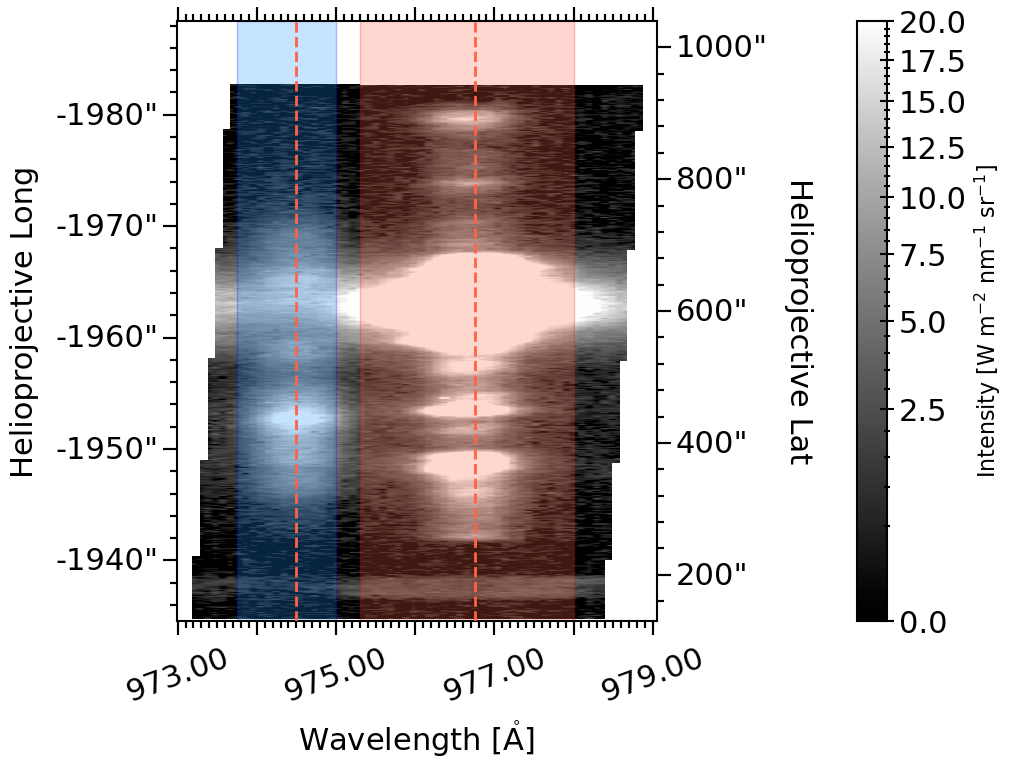

In [9]:
### Here we select a time in the flare to see how much the line is broadened
ind = 88
times = SPICE_anal.grab_time(raster,winid = wind_ciii, nounit = False, verbose = False)
print(times[ind])

wavels_ciii = SPICE_anal.grab_wavel(raster, winid = wind_ciii, verbose = False)

## Make a slice of just the x-position and spectral-position
ndslice_exp_ciii = window_ciii[0,:,:,ind]

## In this we invert the x and y axes to have wavelength along the bottom.
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_exp_ciii.wcs,slices=('y', 'x'))

## Put a '1' at the start to have no normalisation
norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)
im = ax.imshow(ndslice_exp_ciii.data.transpose(), 
               norm = norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.gray)

## Extract the pixel numbers corresponding to the wavelength array
xlimpix_ciii = SPICE_anal.wavel2pix(ndslice_exp_ciii, 
                                    [wavels_ciii[0], wavels_ciii[-1]], 
                                    outputall=False, verbose=False)
ax.set_xlim(xlimpix_ciii[0], xlimpix_ciii[1]) 

## Guess of rest-ish wavelengths of the two lines of interest in this window

ciii = 97.675
fexviii = 97.450

## The pixel numbers for those wavelengths
ciii_pix = SPICE_anal.wavel2pix(ndslice_exp_ciii, ciii, outputall=False, verbose=False)
fexviii_pix = SPICE_anal.wavel2pix(ndslice_exp_ciii, fexviii, outputall=False, verbose=False)

ax.axvline(x=ciii_pix, linestyle = '--', linewidth = 2, color = 'tomato')
ax.axvline(x=fexviii_pix, linestyle = '--', linewidth = 2, color = 'tomato')

## Some formatting and conversion of wavelength axis
ax.coords[2].set_ticklabel(exclude_overlapping=True)
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.xx')
ax.coords[2].set_ticks_position('bt')
ax.coords[2].display_minor_ticks(True)
ax.coords[2].set_minor_frequency(10)
ax.coords[2].set_ticklabel(rotation=20, pad=30)

## Some formatting of spatial axes
ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.coords[2].set_ticks_position('bt')
ax.coords[2].display_minor_ticks(True)
ax.coords[2].set_minor_frequency(10)
ax.tick_params(axis='both', which='both', direction='out')

## The wavelengths that define the extent of the line(s)
w1_ciii = 97.530
w2_ciii = 97.800
wlimpix_ciii = SPICE_anal.wavel2pix(ndslice_exp_ciii, [w1_ciii,w2_ciii], outputall=False, verbose=False)
r_ciii = Rectangle((wlimpix_ciii[0], 0), wlimpix_ciii[1]-wlimpix_ciii[0], ndslice_exp_ciii.data.shape[1], 
                   edgecolor='red', facecolor='tomato', alpha = 0.25)
ax.add_patch(r_ciii)

w1_fexvii = 97.375
w2_fexvii = 97.500
wlimpix_fexviii = SPICE_anal.wavel2pix(ndslice_exp_ciii, [w1_fexvii,w2_fexvii], outputall=False, verbose=False)
r_fexviii = Rectangle((wlimpix_fexviii[0], 0), wlimpix_fexviii[1]-wlimpix_fexviii[0], ndslice_exp_ciii.data.shape[1], 
                     edgecolor='blue', facecolor='dodgerblue', alpha = 0.25)
ax.add_patch(r_fexviii)

cbar = plt.colorbar(im, pad=0.25)
cbar.set_label('Intensity [W m$^{-2}$ nm$^{-1}$ sr$^{-1}$]', size=16)

plt.show()

* Map of the CIII line core intensities, with Fe XVIII contours

/Users/gskerr1/opt/anaconda3/envs/py311_dev/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = super().contour(*args, **kwargs)


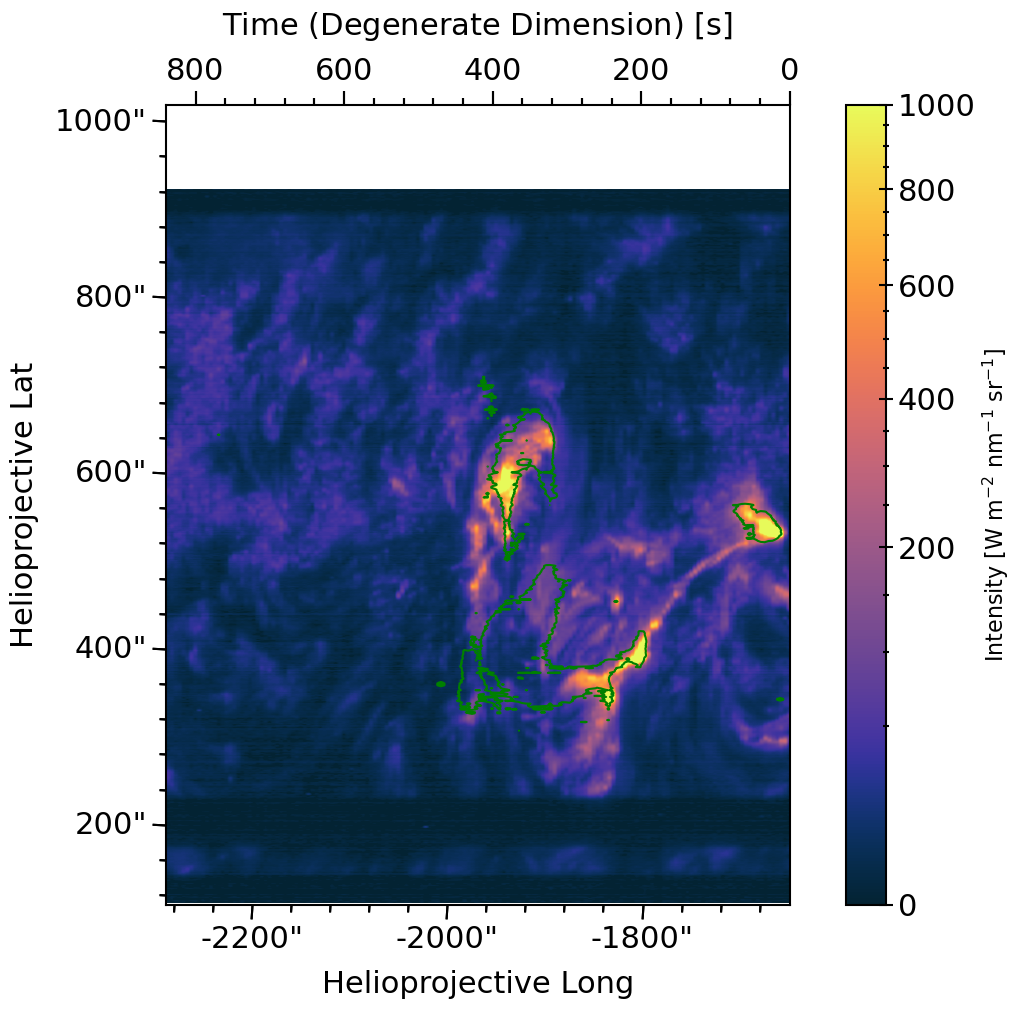

In [10]:
ind_cont = int(fexviii_pix)
ind_im = int(ciii_pix)

ndslice_im = window_ciii[0,ind_im,:,:]
ndslice_cont = window_ciii[0,ind_cont,:,:]

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_im.wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=1000)
im = ax.imshow(ndslice_im.data, 
          norm=norm,
          origin='lower', aspect = 'auto',
          cmap = cmocean.cm.thermal)
im_cont = ax.contour(ndslice_cont.data, 
#                 levels=[5, 10, 20, 30, 40, 50],
                levels= [np.nanmax(ndslice_cont.data)*0.05,
                         np.nanmax(ndslice_cont.data)*0.25,
                         np.nanmax(ndslice_cont.data)*0.50,
                         np.nanmax(ndslice_cont.data)*0.75,
                         np.nanmax(ndslice_cont.data)*0.90], 
                colors='green', 
                linewidth = 3,
                alpha=1)
ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ nm$^{-1}$ sr$^{-1}$]', size=16)


plt.show()

***Ly-beta***

* Identify the wavelengh ranges

375.25 s


2024-02-09 12:27:26 - astropy - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


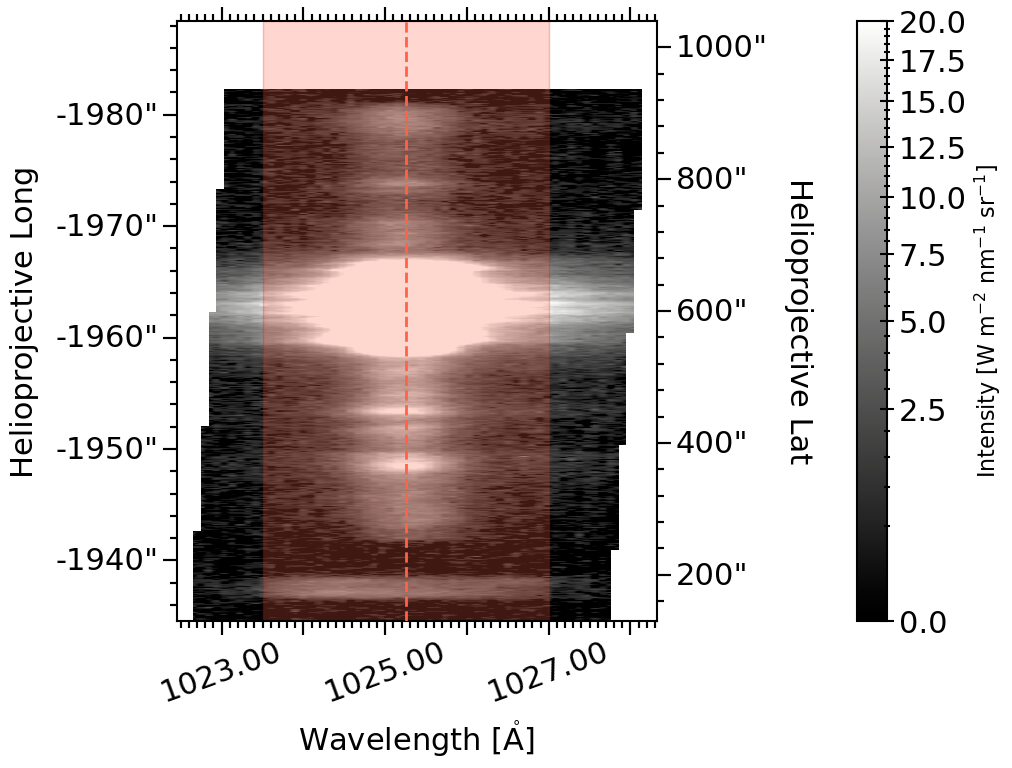

In [11]:
ind = 88
times = SPICE_anal.grab_time(raster, winid = wind_lybeta, nounit = False, verbose = False)
print(times[ind])
wavels_lyb = SPICE_anal.grab_wavel(raster, winid = wind_lybeta, verbose = False)

ndslice_exp_lyb = window_lybeta[0,:,:,ind]

fig = plt.figure(figsize=(10,7.5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_exp_lyb.wcs,slices=('y', 'x'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)
im = ax.imshow(ndslice_exp_lyb.data.transpose(), 
          norm = norm,
          origin='lower', aspect = 'auto',
          cmap = cmocean.cm.gray)

xlimpix_lyb = SPICE_anal.wavel2pix(ndslice_exp_lyb, [wavels_lyb[0], wavels_lyb[-1]], 
                                   outputall=False, verbose=False)
ax.set_xlim(xlimpix_lyb[0], xlimpix_lyb[1]) 

lybet = 102.525

lybet_pix = SPICE_anal.wavel2pix(ndslice_exp_lyb, lybet, outputall=False, verbose=False)

ax.axvline(x=lybet_pix, linestyle = '--', linewidth = 2, color = 'tomato')

## Some formatting and conversion of wavelength axis
ax.coords[2].set_ticklabel(exclude_overlapping=True)
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.xx')
ax.coords[2].set_ticks_position('bt')
ax.coords[2].display_minor_ticks(True)
ax.coords[2].set_minor_frequency(10)
ax.coords[2].set_ticklabel(rotation=20, pad=30)

## Some formatting of spatial axes
ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.coords[2].set_ticks_position('bt')
ax.coords[2].display_minor_ticks(True)
ax.coords[2].set_minor_frequency(10)
ax.tick_params(axis='both', which='both', direction='out')

w1_lybeta = 102.35 
w2_lybeta = 102.70
wlimpix_lyb = SPICE_anal.wavel2pix(ndslice_exp_lyb, [w1_lybeta,w2_lybeta], outputall=False, verbose=False)
r_lyb = Rectangle((wlimpix_lyb[0], 0), wlimpix_lyb[1]-wlimpix_lyb[0], ndslice_exp_lyb.data.shape[1], 
              edgecolor='red', facecolor='tomato', alpha = 0.25)
ax.add_patch(r_lyb)

cbar = plt.colorbar(im, pad=0.25)
cbar.set_label('Intensity [W m$^{-2}$ nm$^{-1}$ sr$^{-1}$]', size=16)

plt.show()

* Plot a map of the Ly-beta line core intensity

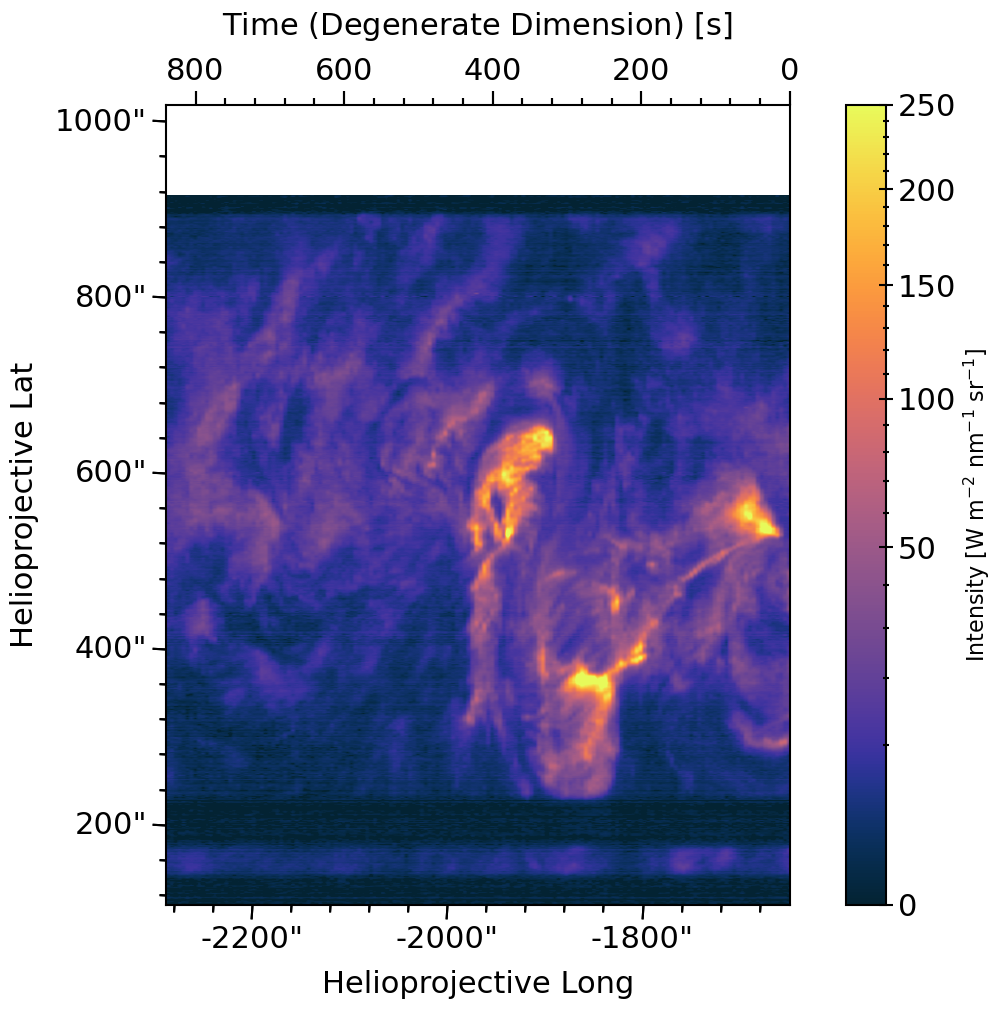

In [12]:
ind_im = int(lybet_pix)

ndslice_im = window_lybeta[0,ind_im,:,:]

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_im.wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=250)
im = ax.imshow(ndslice_im.data, 
          norm=norm,
          origin='lower', aspect = 'auto',
          cmap = cmocean.cm.thermal)

ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ nm$^{-1}$ sr$^{-1}$]', size=16)


plt.show()

***OVI 1032***

* Identify the wavelengh ranges

375.25 s


2024-02-09 12:27:37 - astropy - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


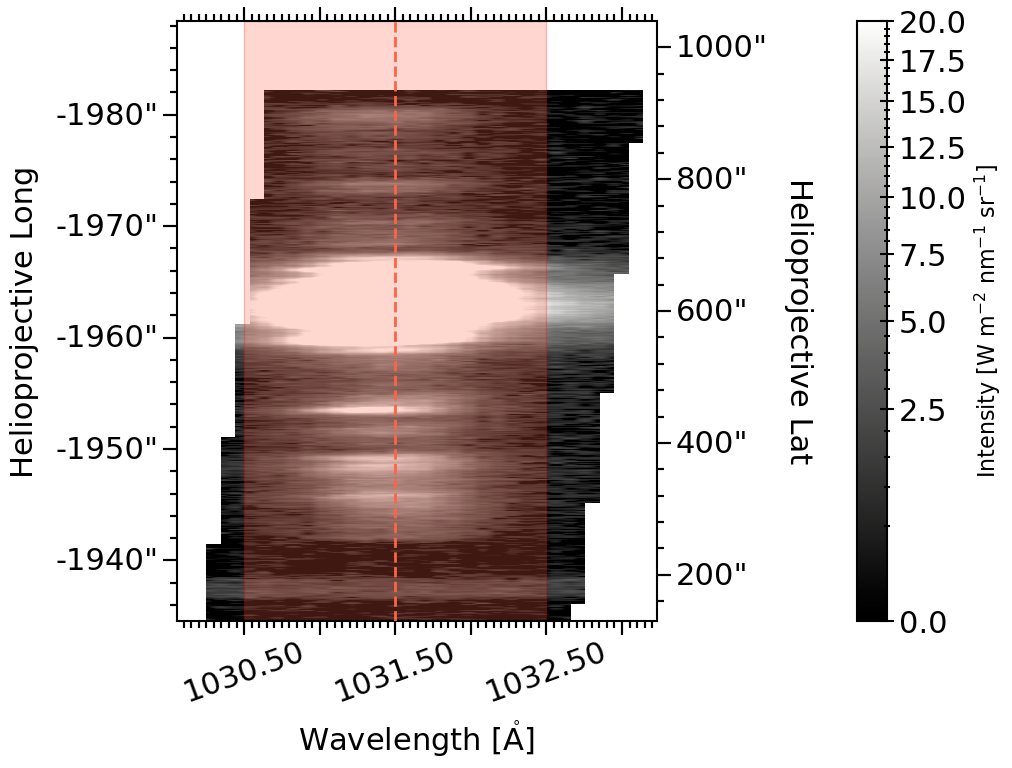

In [13]:
ind = 88
times = SPICE_anal.grab_time(raster, winid = wind_ovi, nounit = False, verbose = False)
print(times[ind])
wavels_ovi = SPICE_anal.grab_wavel(raster, winid = wind_ovi, verbose = False)

ndslice_exp_ovi = window_ovi[0,:,:,ind]

fig = plt.figure(figsize=(10,7.5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_exp_ovi.wcs,slices=('y', 'x'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)
im = ax.imshow(ndslice_exp_ovi.data.transpose(), 
          norm = norm,
          origin='lower', aspect = 'auto',
          cmap = cmocean.cm.gray)

xlimpix_ovi = SPICE_anal.wavel2pix(ndslice_exp_ovi, [wavels_ovi[0], wavels_ovi[-1]], 
                                   outputall=False, verbose=False)
ax.set_xlim(xlimpix_ovi[0], xlimpix_ovi[1]) 

ovi = 103.15

ovi_pix = SPICE_anal.wavel2pix(ndslice_exp_ovi, ovi, outputall=False, verbose=False)


ax.axvline(x=ovi_pix, linestyle = '--', linewidth = 2, color = 'tomato')

## Some formatting and conversion of wavelength axis
ax.coords[2].set_ticklabel(exclude_overlapping=True)
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.xx')
ax.coords[2].set_ticks_position('bt')
ax.coords[2].display_minor_ticks(True)
ax.coords[2].set_minor_frequency(10)
ax.coords[2].set_ticklabel(rotation=20, pad=30)

## Some formatting of spatial axes
ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.coords[2].set_ticks_position('bt')
ax.coords[2].display_minor_ticks(True)
ax.coords[2].set_minor_frequency(10)
ax.tick_params(axis='both', which='both', direction='out')

w1_ovi = 103.050
w2_ovi = 103.250
wlimpix_ovi = SPICE_anal.wavel2pix(ndslice_exp_ovi, [w1_ovi,w2_ovi], outputall=False, verbose=False)
r_ovi = Rectangle((wlimpix_ovi[0], 0), wlimpix_ovi[1]-wlimpix_ovi[0], ndslice_exp_ovi.data.shape[1], 
              edgecolor='red', facecolor='tomato', alpha = 0.25)
ax.add_patch(r_ovi)

cbar = plt.colorbar(im, pad=0.25)
cbar.set_label('Intensity [W m$^{-2}$ nm$^{-1}$ sr$^{-1}$]', size=16)

plt.show()

* Plot a map of the O VI line core

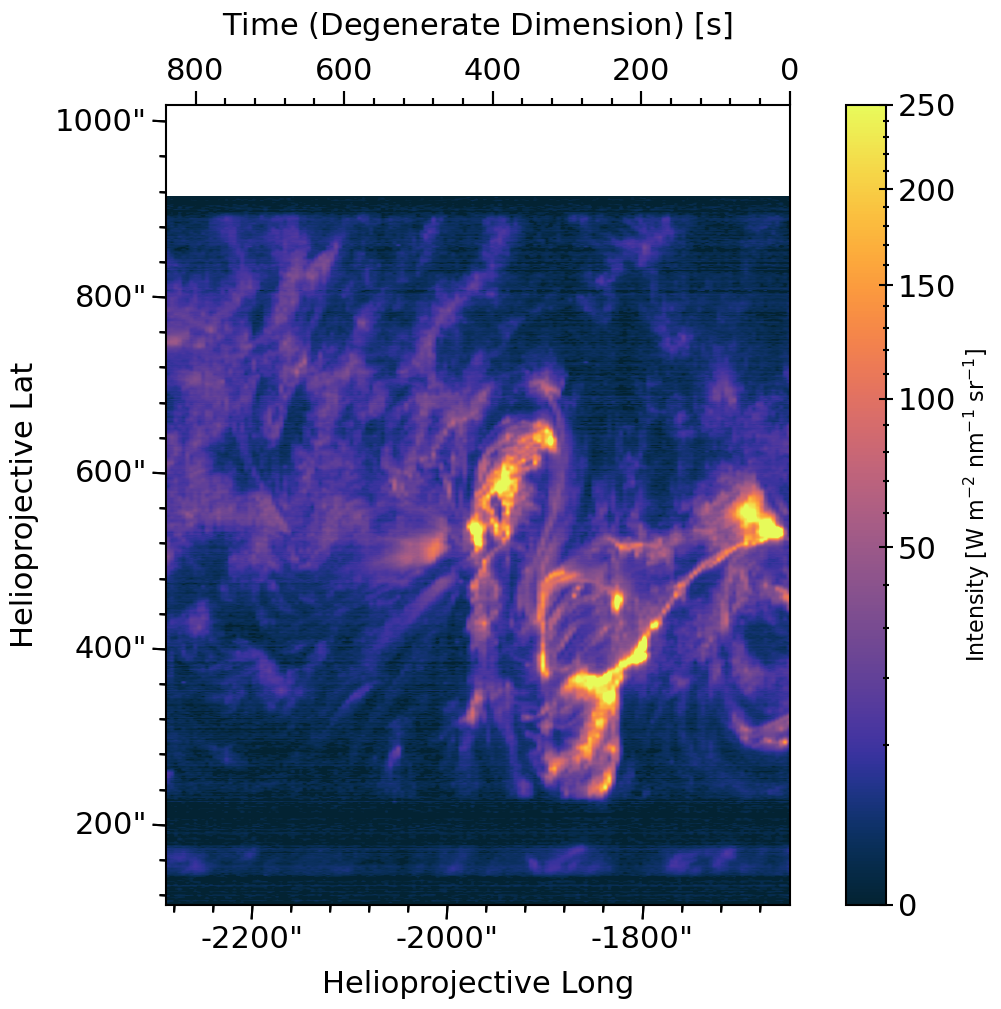

In [14]:
ind_im = int(ovi_pix)

ndslice_im = window_ovi[0,ind_im,:,:]

fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection=ndslice.wcs)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_im.wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=250)
im = ax.imshow(ndslice_im.data, 
          norm=norm,
          origin='lower', aspect = 'auto',
          cmap = cmocean.cm.thermal)

ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ nm$^{-1}$ sr$^{-1}$]', size=16)


plt.show()

### <b style="color:red"> Integrate over wavelengths </b>


***CIII & Fe XVIII***

In [15]:
wavels_ciii

<Quantity [97.2991075, 97.3087305, 97.3183535, 97.3279765, 97.3375995,
           97.3472225, 97.3568455, 97.3664685, 97.3760915, 97.3857145,
           97.3953375, 97.4049605, 97.4145835, 97.4242065, 97.4338295,
           97.4434525, 97.4530755, 97.4626985, 97.4723215, 97.4819445,
           97.4915675, 97.5011905, 97.5108135, 97.5204365, 97.5300595,
           97.5396825, 97.5493055, 97.5589285, 97.5685515, 97.5781745,
           97.5877975, 97.5974205, 97.6070435, 97.6166665, 97.6262895,
           97.6359125, 97.6455355, 97.6551585, 97.6647815, 97.6744045,
           97.6840275, 97.6936505, 97.7032735, 97.7128965, 97.7225195,
           97.7321425, 97.7417655, 97.7513885, 97.7610115, 97.7706345,
           97.7802575, 97.7898805, 97.7995035, 97.8091265, 97.8187495,
           97.8283725, 97.8379955, 97.8476185, 97.8572415, 97.8668645,
           97.8764875, 97.8861105, 97.8957335, 97.9053565] nm>

2024-02-09 12:28:02 - astropy - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


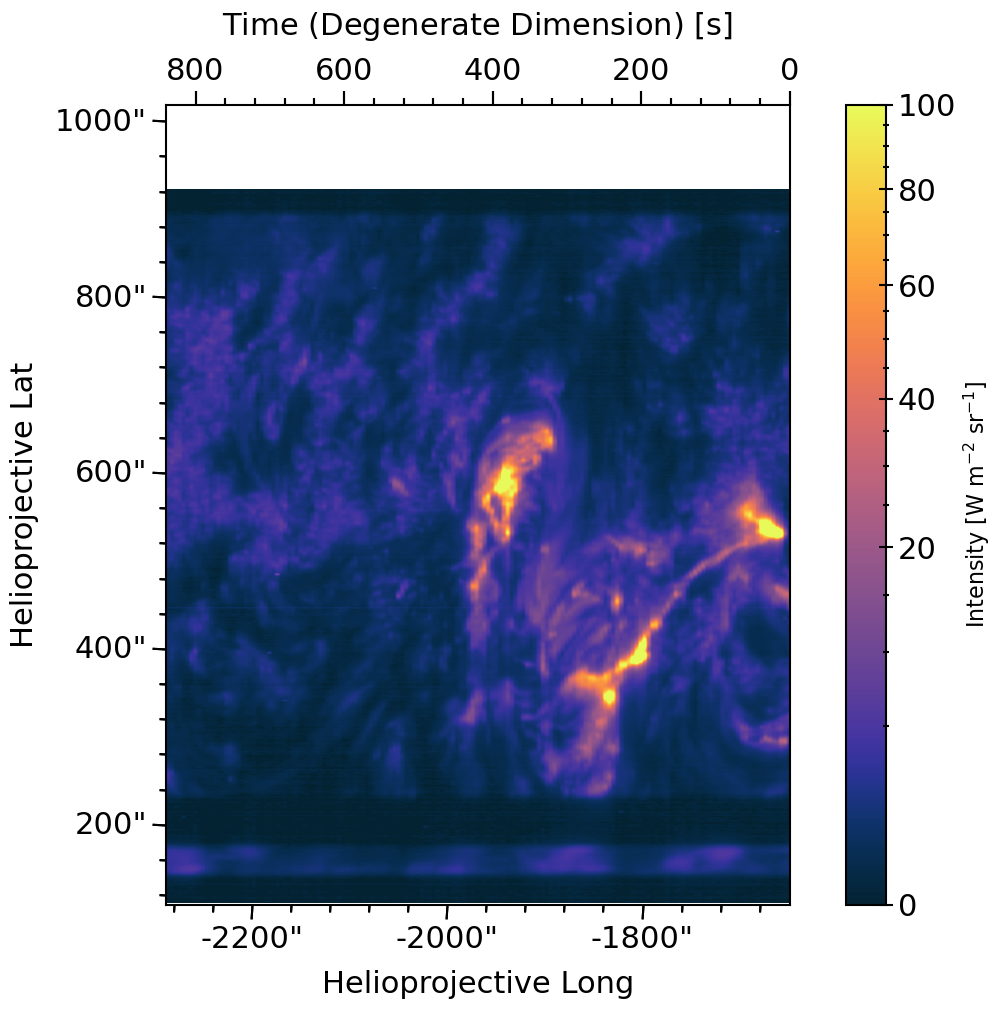

2024-02-09 12:28:06 - astropy - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


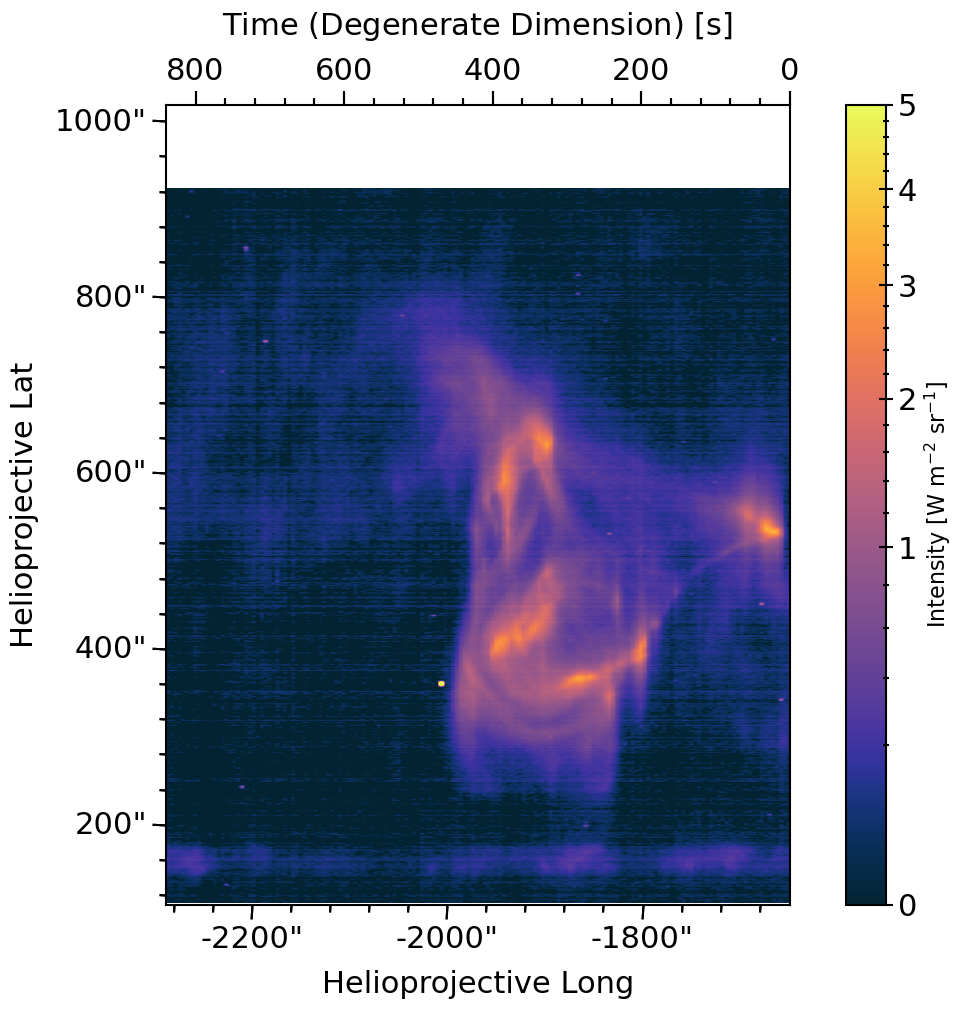

/Users/gskerr1/opt/anaconda3/envs/py311_dev/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = super().contour(*args, **kwargs)


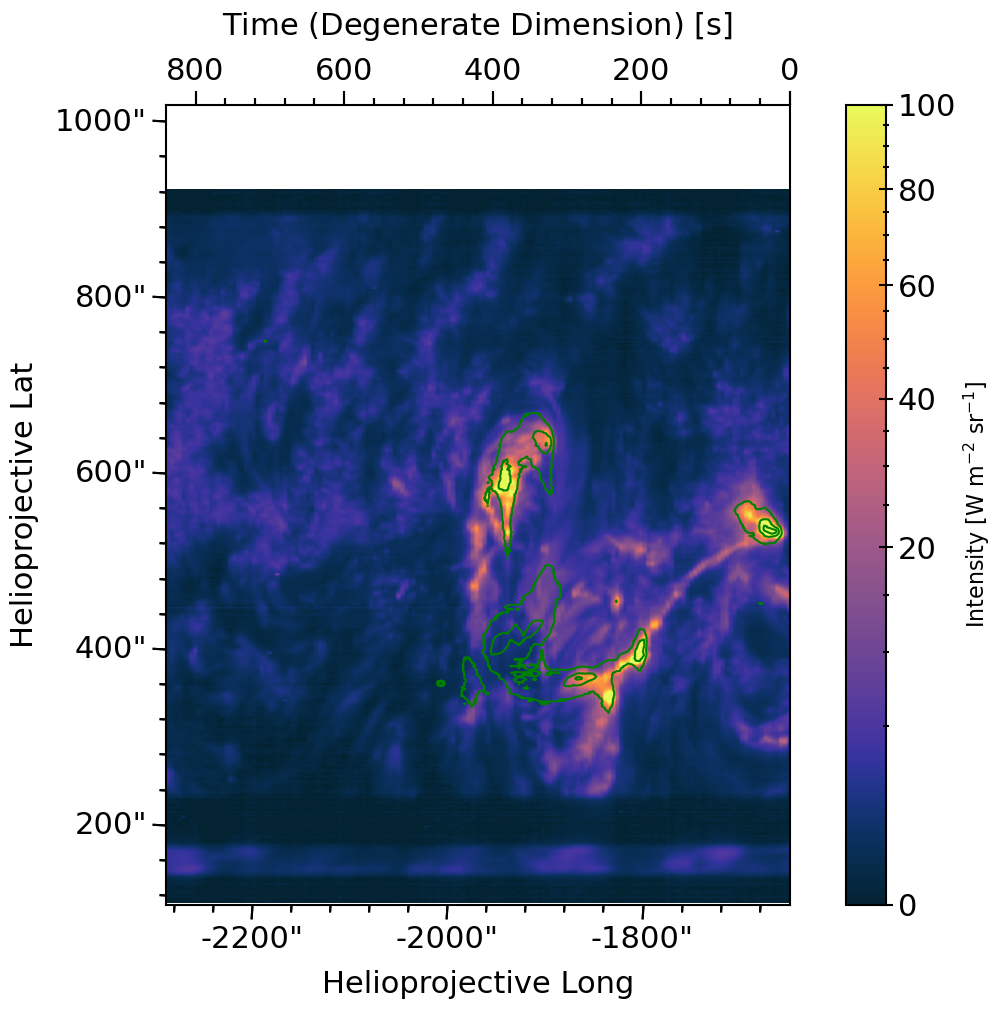

In [16]:
#### CIII
ndslice_ciii_integ = SPICE_anal.wintegrate_trapz(window_ciii, 
                                                 w1 = w1_ciii, w2 = w2_ciii, 
                                                 wavels=wavels_ciii)


fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_ciii_integ[0].wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=100)
im = ax.imshow(ndslice_ciii_integ[0].data, 
               norm=norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.thermal)

ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', size=16)


plt.show()


#### Fe XVIII
ndslice_fexviii_integ = SPICE_anal.wintegrate_trapz(window_ciii, 
                                                    w1 = w1_fexvii, w2 = w2_fexvii, 
                                                    wavels=wavels_ciii)


fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_fexviii_integ[0].wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=5)
im = ax.imshow(ndslice_fexviii_integ[0].data, 
               norm=norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.thermal)

ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', size=16)


plt.show()

#### Together
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_ciii_integ[0].wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=100)
im = ax.imshow(ndslice_ciii_integ[0].data, 
               norm=norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.thermal)
im_cont = ax.contour(ndslice_fexviii_integ[0].data, 
                levels=[1, 2, 3, 4, 5],
#                 levels= [np.nanmax(ndslice_fexviii_integ[0].data)*0.05,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.25,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.50,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.75,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.90], 
                colors='green', 
                linewidth = 3,
                alpha=1)
ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', size=16)


plt.show()

***Ly-beta***

2024-02-09 12:28:12 - astropy - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


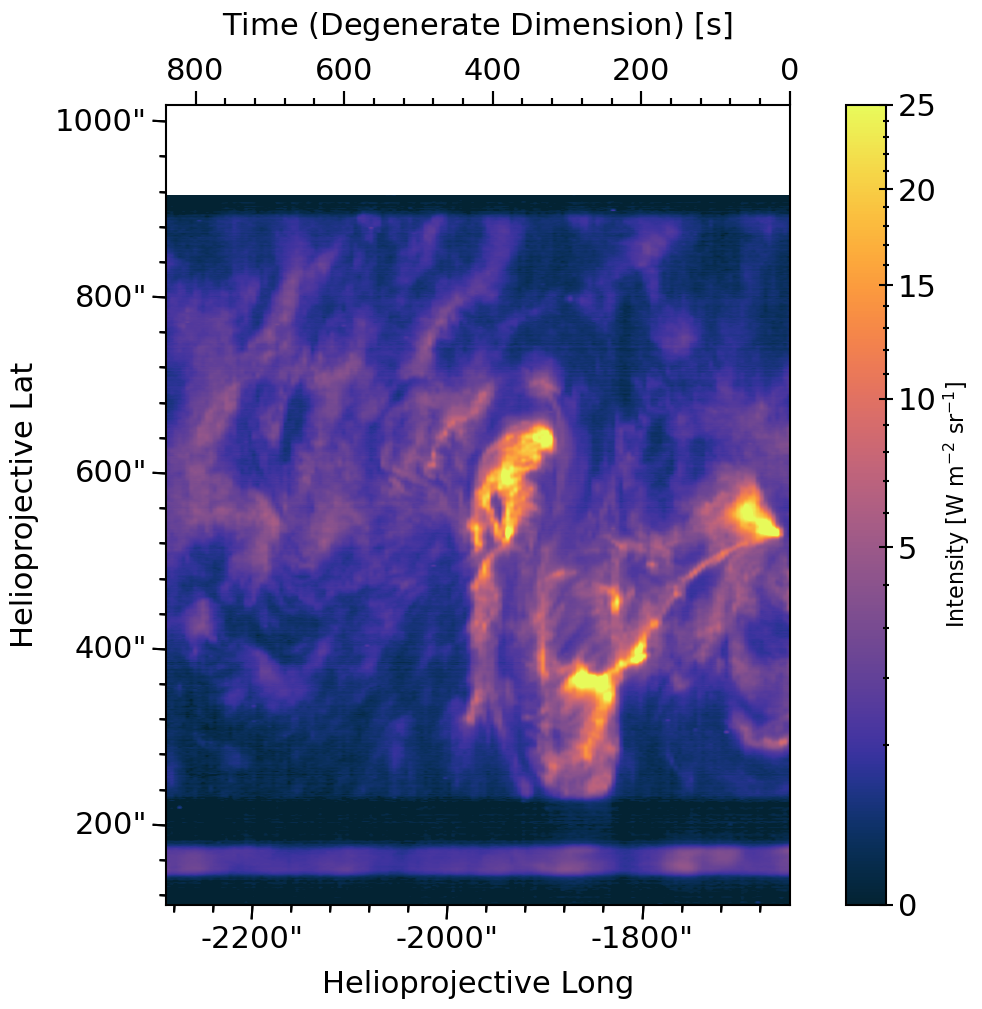

In [17]:
ndslice_lyb_integ = SPICE_anal.wintegrate_trapz(window_lybeta, 
                                                 w1 = w1_lybeta, w2 = w2_lybeta, 
                                                 wavels=wavels_lyb)


fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_lyb_integ[0].wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=25)
im = ax.imshow(ndslice_lyb_integ[0].data, 
               norm=norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.thermal)

ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', size=16)


plt.show()

***O VI 1302***

2024-02-09 12:28:24 - astropy - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


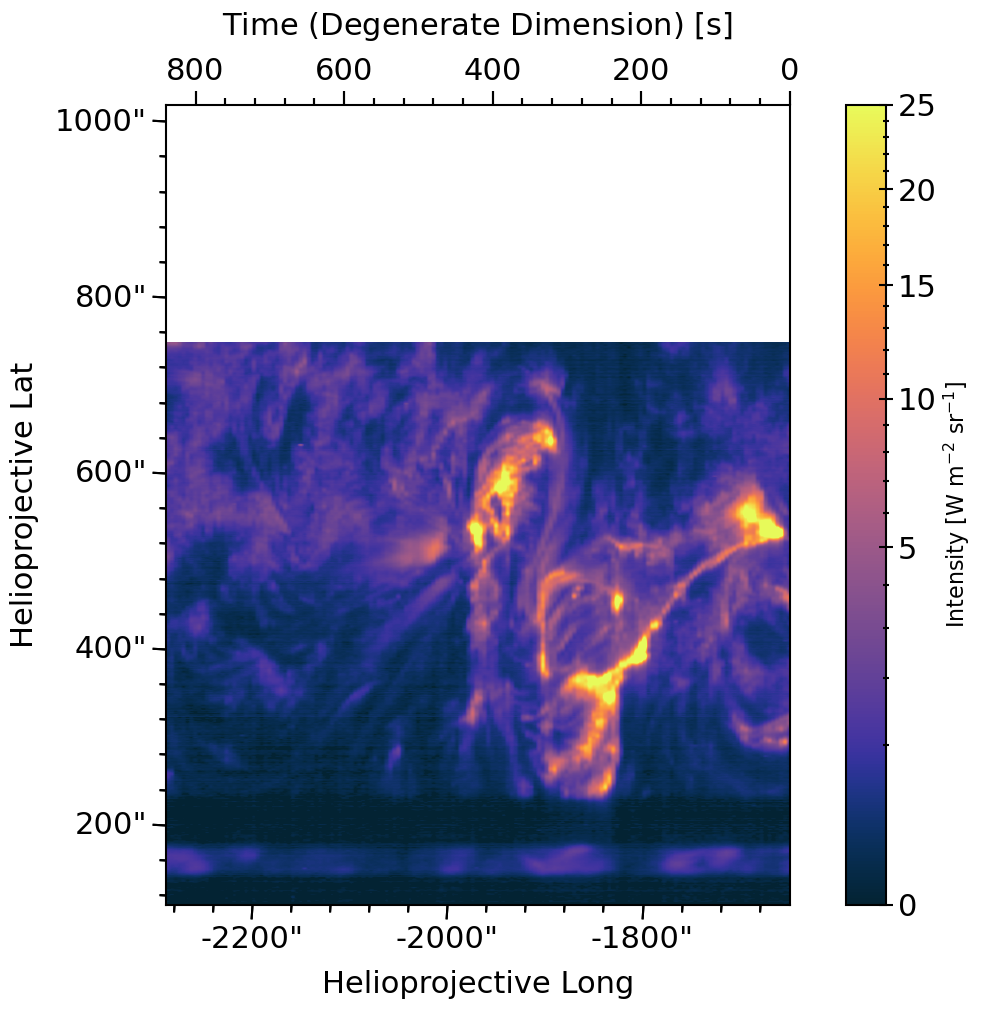

In [18]:
ndslice_ovi_integ = SPICE_anal.wintegrate_trapz(window_ovi, 
                                                 w1 = w1_ovi, w2 = w2_ovi, 
                                                 wavels=wavels_ovi)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_ovi_integ[0].wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=25)
im = ax.imshow(ndslice_ovi_integ[0].data, 
               norm=norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.thermal)

ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', size=16)


plt.show()

***Overlay different windows***

* C III and Lyb

/Users/gskerr1/opt/anaconda3/envs/py311_dev/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = super().contour(*args, **kwargs)


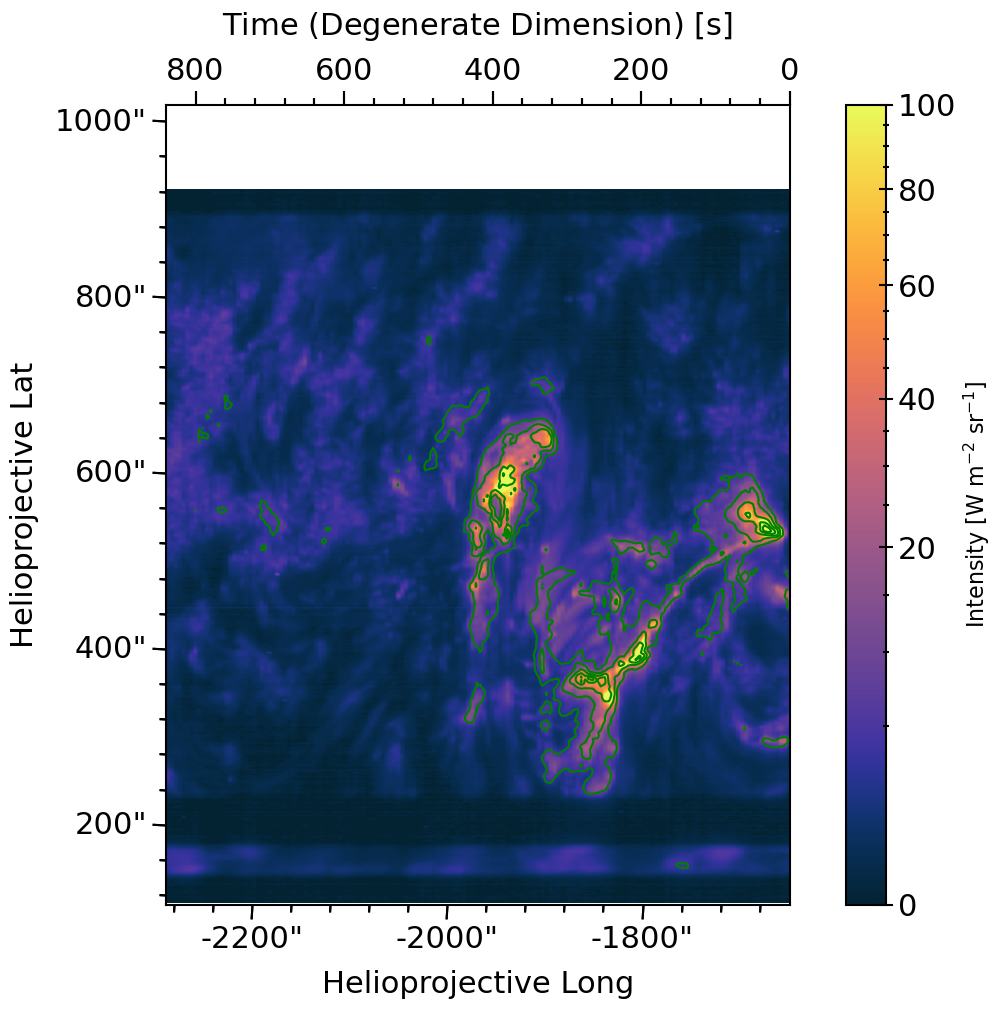

In [19]:
#### CIII
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_ciii_integ[0].wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=100)
im = ax.imshow(ndslice_ciii_integ[0].data, 
               norm=norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.thermal)
im_cont = ax.contour(ndslice_lyb_integ[0].data, 
                     transform=ax.get_transform(ndslice_lyb_integ[0].wcs),
#                 levels=[1, 2, 3, 4, 5],
                levels= [np.nanmax(ndslice_lyb_integ[0].data)*0.10,
                         np.nanmax(ndslice_lyb_integ[0].data)*0.25,
                         np.nanmax(ndslice_lyb_integ[0].data)*0.50,
                         np.nanmax(ndslice_lyb_integ[0].data)*0.75,
                         np.nanmax(ndslice_lyb_integ[0].data)*0.90], 
                colors='green', 
                linewidth = 3,
                alpha=1)
ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', size=16)


plt.show()



* Lyb and Fe XVIII

/Users/gskerr1/opt/anaconda3/envs/py311_dev/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = super().contour(*args, **kwargs)


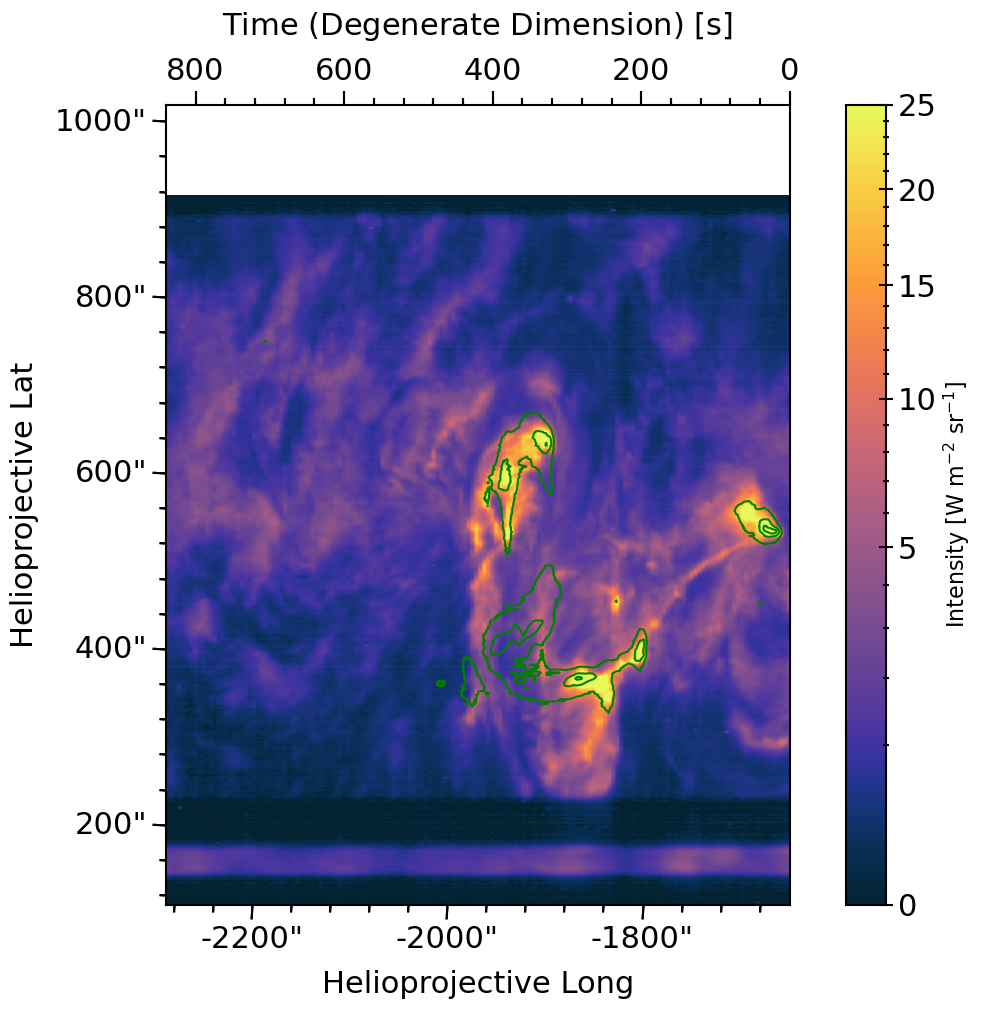

In [20]:
#### CIII
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_lyb_integ[0].wcs,slices=('x', 'y'))

norm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=25)
im = ax.imshow(ndslice_lyb_integ[0].data, 
               norm=norm,
               origin='lower', aspect = 'auto',
               cmap = cmocean.cm.thermal)
im_cont = ax.contour(ndslice_fexviii_integ[0].data, 
                     transform=ax.get_transform(ndslice_fexviii_integ[0].wcs),
                levels=[1, 2, 3, 4, 5],
#                 levels= [np.nanmax(ndslice_fexviii_integ[0].data)*0.10,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.25,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.50,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.75,
#                          np.nanmax(ndslice_fexviii_integ[0].data)*0.90], 
                colors='green', 
                linewidth = 3,
                alpha=1)
ax.coords[0].set_axislabel('Helioprojective Long')
ax.coords[1].set_axislabel('Helioprojective Lat')
ax.tick_params(axis='both', which='both', direction='out')

cbar = plt.colorbar(im, pad=0.07)
cbar.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', size=16)


plt.show()


---
---
---
### <b style="color:blue"> Line plots with error bars </b>


***Line plot using WCS slicing***

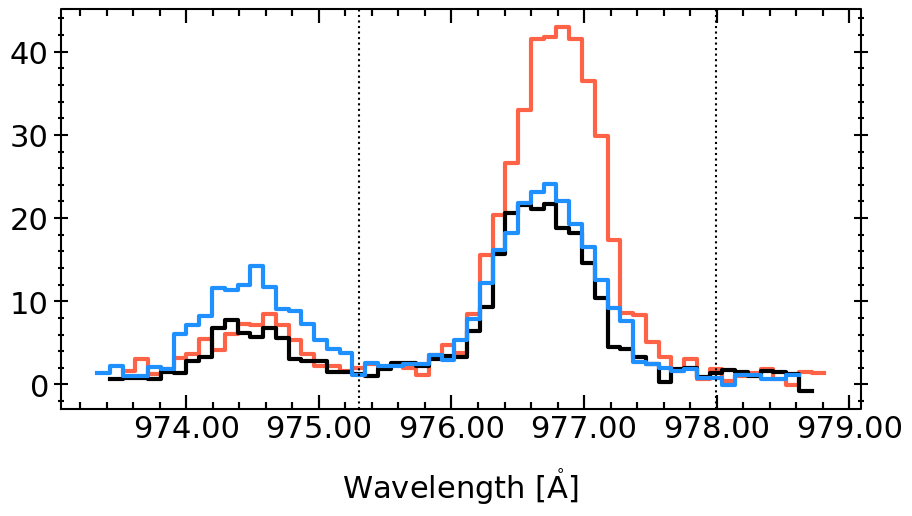

In [21]:
fig = plt.figure(figsize=(10,5))

xind = 80 ## xindex (ie. time)
yind = [530, 500, 230] ## pixels along slit

ndslice_line = window_ciii[0,:,:,xind]

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ndslice_line.wcs,slices=(yind[0], 'x'))
ax.plot(ndslice_line.data[:,yind[0]], linewidth = 3, color = 'tomato', drawstyle = 'steps-mid')
ax.plot(ndslice_line.data[:,yind[1]], linewidth = 3, color = 'black', drawstyle = 'steps-mid')
ax.plot(ndslice_line.data[:,yind[2]], linewidth = 3, color = 'dodgerblue', drawstyle = 'steps-mid')

ax.coords[2].set_ticklabel(exclude_overlapping=True)
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.xx')

ax.axvline(x=int(np.round(wlimpix_ciii)[0]), linestyle = ':', color = 'black')
ax.axvline(x=int(np.round(wlimpix_ciii)[1]), linestyle = ':', color = 'black')

plt.show()

***Line plot without WCS slicing (ie just mpl)***

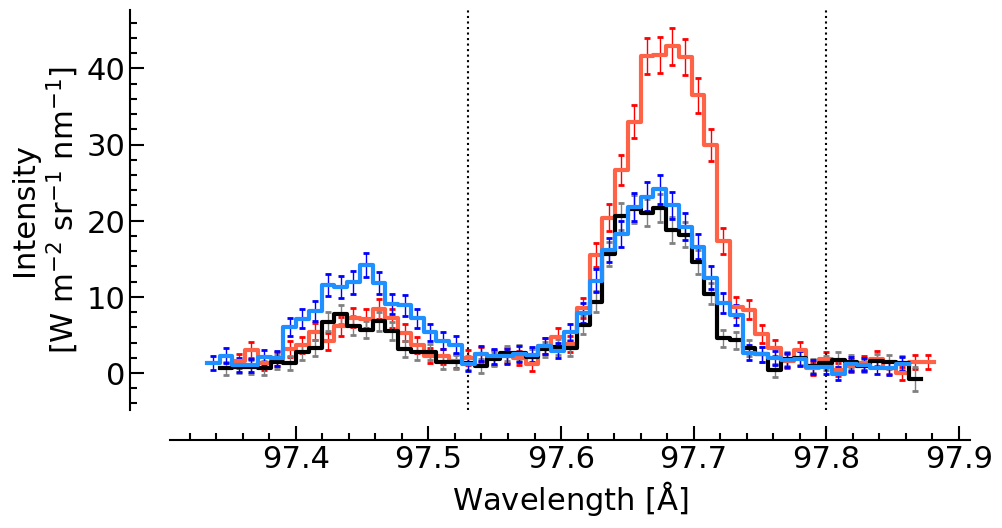

In [22]:
### I think we just do manual figure for errorbar, wcs doesn't play well with it (during my quick test at least)
plot_dict = utils.plotsetup(font_size = 22)
plt.rcParams.update(plot_dict)

fig = plt.figure(figsize=(10,5))

xind = 80 ## xindex (ie. time)
yind = [530, 500, 230] ## pixels along slit

data = window_ciii.data[0,:,:,xind]

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.errorbar(wavels_ciii,
            ndslice_line.data[:,yind[0]],
            yerr = ndslice_line.uncertainty.array[:,yind[0]],
            ecolor = 'red', elinewidth = 1, capsize = 2, capthick = 2,
            linewidth = 3, color = 'tomato', drawstyle = 'steps-mid')
ax.errorbar(wavels_ciii,
            ndslice_line.data[:,yind[1]],
            yerr = ndslice_line.uncertainty.array[:,yind[1]],
            ecolor = 'grey', elinewidth = 1, capsize = 2, capthick = 2,
            linewidth = 3, color = 'black', drawstyle = 'steps-mid')
ax.errorbar(wavels_ciii,
            ndslice_line.data[:,yind[2]],
            yerr = ndslice_line.uncertainty.array[:,yind[2]],
            ecolor = 'blue', elinewidth = 1, capsize = 2, capthick = 2,
            linewidth = 3, color = 'dodgerblue', drawstyle = 'steps-mid')

ax.axvline(x=w1_ciii, linestyle = ':', color = 'black')
ax.axvline(x=w2_ciii, linestyle = ':', color = 'black')

ax.set_ylabel('Intensity\n[W m$^{-2}$ sr$^{-1}$ nm$^{-1}$]')
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')

ax.spines["bottom"].set_position(("axes",-.075))
ax.spines["left"].set_position(("axes",-.05))

plt.show()